# 1. Install Dependencies and Setup

In [2]:
!pip install tensorflow opencv-python matplotlib

In [10]:
!pip list

Package                      Version
---------------------------- -----------
absl-py                      2.1.0
asttokens                    2.4.1
astunparse                   1.6.3
cachetools                   5.3.3
certifi                      2024.2.2
charset-normalizer           3.3.2
colorama                     0.4.6
comm                         0.2.2
contourpy                    1.2.1
cycler                       0.12.1
debugpy                      1.8.1
decorator                    5.1.1
exceptiongroup               1.2.1
executing                    2.0.1
flatbuffers                  24.3.25
fonttools                    4.52.4
gast                         0.4.0
google-auth                  2.29.0
google-auth-oauthlib         0.4.6
google-pasta                 0.2.0
grpcio                       1.64.0
h5py                         3.11.0
idna                         3.7
importlib_metadata           7.1.0
importlib_resources          6.4.0
ipykernel                    6.29.4
ipy

In [1]:
import tensorflow as tf
import os

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

# 2. Remove dodgy images

In [5]:
import cv2
import imghdr

In [6]:
data_dir = 'data' 

In [7]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [8]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [9]:
import numpy as np
from matplotlib import pyplot as plt

In [10]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 547 files belonging to 2 classes.


In [11]:
data

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
data_iterator

In [14]:
batch = data_iterator.next()

In [15]:
#1=>Sad 
#0=>Happy
batch[1]

array([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 0])

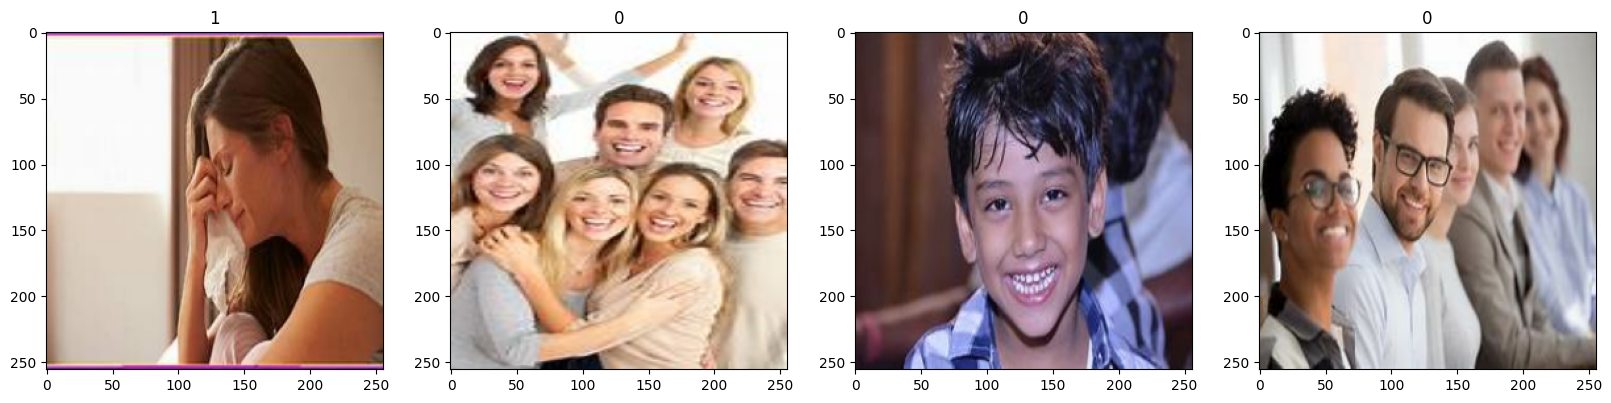

In [16]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [17]:
data = data.map(lambda x,y: (x/255, y))

In [18]:
data.as_numpy_iterator().next()

(array([[[[0.99215686, 0.99215686, 0.99215686],
          [0.99215686, 0.99215686, 0.99215686],
          [0.99215686, 0.99215686, 0.99215686],
          ...,
          [0.99215686, 0.99215686, 0.99215686],
          [0.99215686, 0.99215686, 0.99215686],
          [0.99215686, 0.99215686, 0.99215686]],
 
         [[0.99215686, 0.99215686, 0.99215686],
          [0.99215686, 0.99215686, 0.99215686],
          [0.99215686, 0.99215686, 0.99215686],
          ...,
          [0.99215686, 0.99215686, 0.99215686],
          [0.99215686, 0.99215686, 0.99215686],
          [0.99215686, 0.99215686, 0.99215686]],
 
         [[0.99215686, 0.99215686, 0.99215686],
          [0.99215686, 0.99215686, 0.99215686],
          [0.99215686, 0.99215686, 0.99215686],
          ...,
          [0.99215686, 0.99215686, 0.99215686],
          [0.99215686, 0.99215686, 0.99215686],
          [0.99215686, 0.99215686, 0.99215686]],
 
         ...,
 
         [[0.96962315, 0.8090533 , 0.691299  ],
          [0.97367

# 5. Split Data

In [20]:
len(data)

18

In [24]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [25]:
train_size +val_size+test_size

18

In [26]:
test_size

2

In [27]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [29]:
model = Sequential()

In [30]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [31]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 7. Train

In [33]:
logdir='logs'

In [34]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [35]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
12/12 [==============================] - 20s 447ms/step - loss: 0.8138 - accuracy: 0.5703 - val_loss: 0.6214 - val_accuracy: 0.7969
Epoch 2/20
12/12 [==============================] - 1s 107ms/step - loss: 0.6497 - accuracy: 0.6432 - val_loss: 0.5754 - val_accuracy: 0.7031
Epoch 3/20
12/12 [==============================] - 1s 103ms/step - loss: 0.5681 - accuracy: 0.7031 - val_loss: 0.5184 - val_accuracy: 0.7656
Epoch 4/20
12/12 [==============================] - 1s 102ms/step - loss: 0.5149 - accuracy: 0.7630 - val_loss: 0.4475 - val_accuracy: 0.7812
Epoch 5/20
12/12 [==============================] - 1s 102ms/step - loss: 0.4209 - accuracy: 0.8047 - val_loss: 0.3591 - val_accuracy: 0.8672
Epoch 6/20
12/12 [==============================] - 1s 103ms/step - loss: 0.3562 - accuracy: 0.8672 - val_loss: 0.3210 - val_accuracy: 0.9062
Epoch 7/20
12/12 [==============================] - 1s 103ms/step - loss: 0.2767 - accuracy: 0.8906 - val_loss: 0.3018 - val_accuracy: 0.8516
Epoch

# 8. Plot Performance

In [36]:
hist.history


{'loss': [0.81378573179245,
  0.6496739983558655,
  0.568127453327179,
  0.5149036049842834,
  0.4208759367465973,
  0.35620829463005066,
  0.2767435908317566,
  0.300709068775177,
  0.2880973517894745,
  0.1992216557264328,
  0.17524020373821259,
  0.1211743876338005,
  0.09498085826635361,
  0.08026397973299026,
  0.03694288432598114,
  0.029301201924681664,
  0.038441285490989685,
  0.02308267541229725,
  0.01360634807497263,
  0.023527098819613457],
 'accuracy': [0.5703125,
  0.6432291865348816,
  0.703125,
  0.7630208134651184,
  0.8046875,
  0.8671875,
  0.890625,
  0.8723958134651184,
  0.8932291865348816,
  0.921875,
  0.953125,
  0.9661458134651184,
  0.96875,
  0.9765625,
  0.9921875,
  0.9895833134651184,
  0.9895833134651184,
  0.9947916865348816,
  0.9973958134651184,
  0.9973958134651184],
 'val_loss': [0.6214044690132141,
  0.5754121541976929,
  0.518427848815918,
  0.447475790977478,
  0.35910463333129883,
  0.3209795355796814,
  0.30183762311935425,
  0.396333187818527

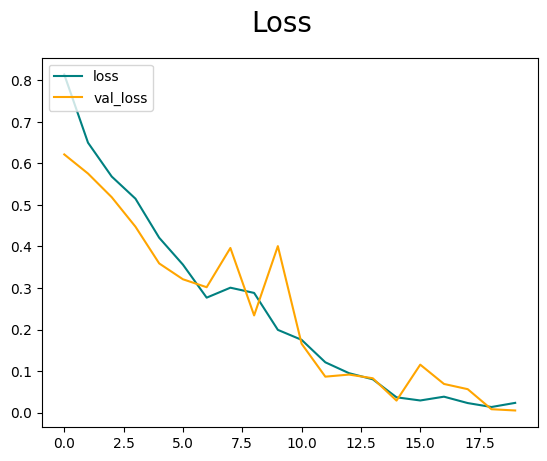

In [37]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

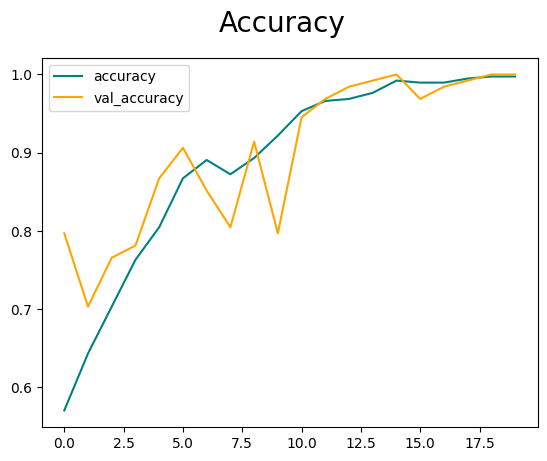

In [38]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [39]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [40]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [41]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 249ms/step


In [42]:
print(f'Precision:{pre.result().numpy()},Recall:{re.result().numpy()}, Accuracy : {acc.result().numpy()}')

Precision:1.0,Recall:1.0, Accuracy : 1.0


# 10. Test

In [43]:
import cv2

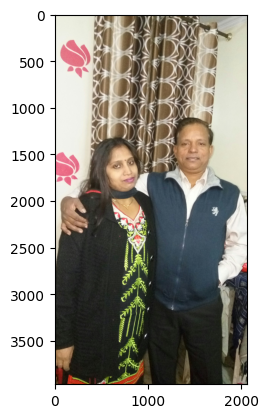

In [44]:
img = cv2.imread('happ.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

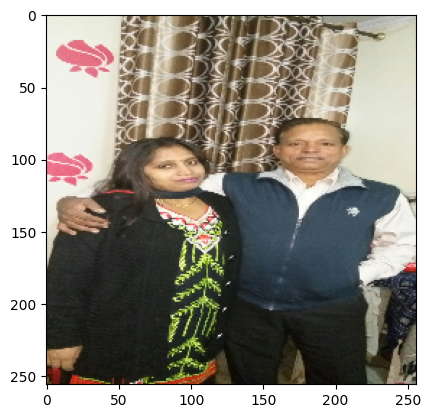

In [45]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [46]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 297ms/step


In [47]:
yhat

array([[0.24117695]], dtype=float32)

In [48]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [49]:
from tensorflow.keras.models import load_model

In [50]:
model.save(os.path.join('models','happysadimagemodel2.h5'))

In [51]:
new_model = load_model(os.path.join('models','happysadimagemodel2.h5'))

In [52]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 108ms/step


array([[0.24117695]], dtype=float32)